In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

In [2]:
def returns(mu, sig):
    #print(mu.shape, sig.shape)
    return np.random.multivariate_normal(mean = mu, cov = sig)

def ideal(x, beta, mu, sigma):
    return beta*np.dot(sigma, x) - mu

def theta_star(mu, sigma, beta):
    return np.dot(np.linalg.inv(sigma), mu/beta)

def sr(x, mu, sigma, beta, lamda):
    return -np.dot(mu, x) + 0.5*beta*np.dot(x,np.dot(sigma, x)) - np.log(beta)/lamda

def loss_dash(x, beta):
    return -beta*np.exp(beta*x)

def generate_zeta_samples(mu, sigma, theta, m):
    zeta_samples = []
    for i in range(m):
        r = returns(mu, sigma)
        zeta_samples.append([-np.dot(theta, r),-r])
    return zeta_samples

def estimate_h(mu, sigma, beta, theta, sr,  m):
    zeta_samples = generate_zeta_samples(mu, sigma, theta, m)
    A_m = 0
    B_m = 0
    for i in range(m):
        A_m += loss_dash(zeta_samples[i][0] - sr, beta)*zeta_samples[i][1]
        B_m += loss_dash(zeta_samples[i][0] - sr, beta)
    h = A_m/B_m
    return h

def generate_params(size):
    # m zeta samples
    mu = np.random.uniform(0.04, 0.5, size)
    sigma = np.diag(mu+0.05)
    for i in range(size):
        for j in range(i+1, size):
            sigma[i][j] = 0.35*(sigma[i][i])*(sigma[j][j])
            sigma[j][i] = sigma[i][j]
    # print(np.array_str(sigma, precision=2, suppress_small=True))
    # print("mean returns: ", mu)

    return mu, sigma

In [41]:

np.random.seed(0)

MAX_ITER = 1000
size = 10
m = 100
beta = 0.5
lamda = 0.1
c = 1


decay = [True, False, False, False, False]
cc = [1, 10, 1, 0.1, 0.01]

# ploth with 4 different constants  [1, 0.1, 0.01] with 100 experiments and mean over it

# If possible, then show the decaying step size


theta_estimates_exp = []
sr_estimates_exp = []

mu, sigma = generate_params(size)
theta = np.random.uniform(0, 1, size)
theta_init = theta/np.sum(theta)

true_val = theta_star(mu, sigma, beta)
print("True value for theta_1 = ", true_val[0])


for i, c in enumerate(cc):
    dd = decay[i]
    #conduct 100 experiments

    theta = deepcopy(theta_init)
    theta_estimates = [theta]
    sr_estimates = [sr(theta, mu, sigma, beta, lamda)]

    sr_val_theta_star = sr(true_val, mu, sigma, beta, lamda)

    dd = True

    for i in range(1, MAX_ITER):
        # Generate samples for zeta
        sr_val = sr(theta, mu, sigma, beta, lamda)

        estimate = estimate_h(mu, sigma, beta, theta, sr_val,  m)
        #print("Iteration: ", i, "Estimate: ", estimate[-1])
        if dd:
            theta = theta - c*estimate/i
        else:
            theta = theta - c*estimate
        theta_estimates.append(theta)
        sr_estimates.append(sr(theta, mu, sigma, beta, lamda))
        
    theta_estimates_exp.append(theta_estimates)
    sr_estimates_exp.append(sr_estimates)

True value for theta_1 =  0.7532233231958153


## constrained markowitz version experiments

In [1]:
## add extra term in the gd update step to add lagarnagian lambda * ( empirical mean ^T X  - r_0) * Empirical mean to the update step with fixed lagarangian multiplier

In [38]:
print(b)
print(a)

[ 1  2  3  4  5  6  7  8  9 10]
[0 1 2 3 4 5 6 7 8 9]


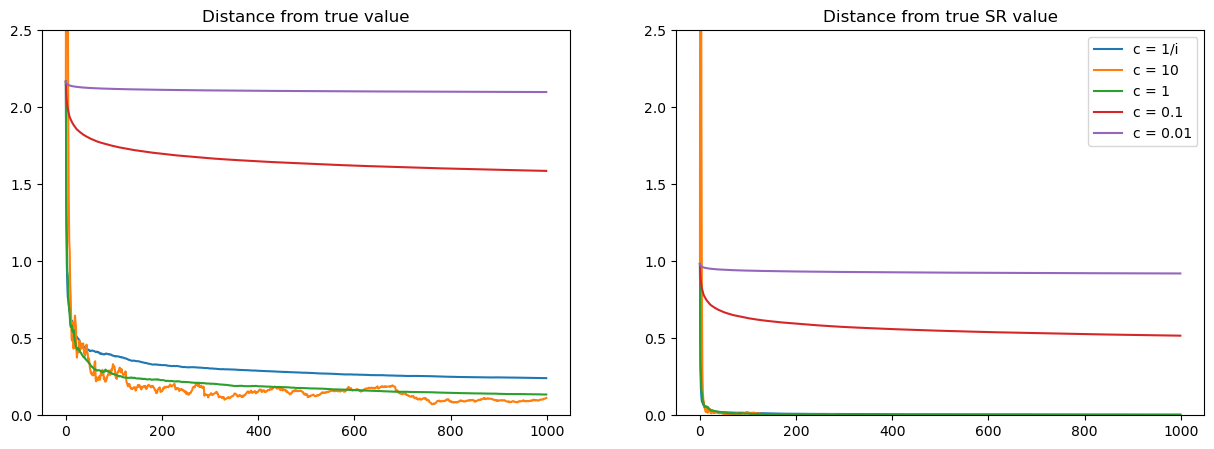

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

custom_ylim = (0, 2.5)

# Setting the values for all axes.
plt.setp(axs, ylim=custom_ylim)

labels = ["c = " + str(cc[i]) + "/i"*decay[i] for i in range(len(cc))]

theta_error = []
sr_error = []

for i in range(len(cc)):
    
    theta_estimates = theta_estimates_exp[i]
    sr_estimates = sr_estimates_exp[i]

    theta_error.append(np.linalg.norm(theta_estimates - true_val, axis=1))
    sr_error.append(np.abs(sr_estimates - sr_val_theta_star))

    axs[0].plot(range(MAX_ITER), theta_error[-1], label = labels[i])
    axs[0].set_title("Distance from true value")

    axs[1].ylim = (0, 0.1)
    axs[1].plot(range(MAX_ITER), sr_error[-1], label = labels[i])
    axs[1].set_title("Distance from true SR value")


plt.legend()
plt.show()

In [52]:
labels

['c = 1/i', 'c = 10', 'c = 1', 'c = 0.1', 'c = 0.01']

In [54]:
theta_error = np.array(theta_error)
sr_error = np.array(sr_error)

df_theta = pd.DataFrame(theta_error.T, columns = labels)
df_sr = pd.DataFrame(sr_error.T, columns = labels)

df_sr.head()

,c = 1/i,c = 10,c = 1,c = 0.1,c = 0.01
0,0.982357,0.982357,0.982357,0.982357,0.982357
1,0.300189,6.786429,0.367350,0.903210,0.973919
2,0.172930,4.240258,0.266492,0.867732,0.970522
3,0.119637,1.958326,0.164463,0.843485,0.967492
4,0.090079,0.794016,0.152074,0.825369,0.965152


In [59]:
# saving all elements as column into a txt file

df_theta.to_csv("theta_error.txt")
df_sr.to_csv("sr_error.txt")

In [57]:
np.savetxt("theta_error.txt", theta_error, delimiter=" ")
np.savetxt("sr_error.txt", sr_error, delimiter=" ")

In [67]:

for i, theta_estimates in enumerate(theta_estimates_c):

    sr_estimates = sr_estimates_c[i]

    norm_diff = np.linalg.norm(theta_estimates - true_val, axis=1)
    sr_diff = np.array(sr_estimates - sr_val_theta_star)

    filename = 'theta_estimates.csv'

    print(norm_diff.shape, sr_diff.shape)

    #     # Open the file in write mode
    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        if i ==0:
            writer.writerow(np.arange(MAX_ITER))

            # Transpose the data list to convert rows into columns
        # Write each list as a row in the CSV file
        writer.writerow(np.around(norm_diff, decimals=2))
    
    filename = 'sr_estimates.csv'
    # Open the file in write mode
    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        if i ==0:
            writer.writerow(np.arange(MAX_ITER))
        # Write each list as a row in the CSV file
        # Transpose the data list to convert rows into columns
        writer.writerow(np.around(sr_diff, decimals=2))
    print(len(theta_estimates), len(norm_diff))

    # plt.plot(norm_diff)
    # plt.title(f"Norm of difference between theta_n and theta_star , c ={cc[i]}")
    # plt.show()

    # plt.plot(sr_diff)
    # plt.title(f"SR estimation for theta_n and theta_star, c ={cc[i]}")
    # plt.show()

(1000,) (1000,)
1000 1000
(1000,) (1000,)
1000 1000
(1000,) (1000,)
1000 1000
(1000,) (1000,)
1000 1000
(1000,) (1000,)
1000 1000


In [66]:
# Saving the array
np.savetxt("theta.csv", np.linalg.norm(theta_estimates_c - true_val, axis=0), delimiter=",")
# Saving the array
np.savetxt("sr.csv", np.array(sr_estimates_c - sr_val_theta_star), delimiter=",")

ValueError: Expected 1D or 2D array, got 0D array instead

In [69]:

def transpose_it(filename):
    # Define the file names
    input_file = 'input.csv'
    output_file = 'output.csv'

    # Read the input CSV file and transpose the data
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        data = list(zip(*reader))

    # Write the transposed data to the output CSV file
    with open("new"+filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(data)

transpose_it('sr_estimates.csv')


In [11]:
data = [ (xx,yy,zz) for xx, yy, zz in zip(x,y,z)]

# save data to txt file

print(data)

np.savetxt("data.txt", data, fmt="%s")

[(1, 2.0, 0.51), (2, 1.49, 0.28), (3, 1.23, 0.19), (4, 1.12, 0.16), (5, 1.04, 0.14), (6, 0.99, 0.12), (7, 0.95, 0.11), (8, 0.9, 0.1), (9, 0.86, 0.09), (10, 0.81, 0.08), (11, 0.79, 0.08), (12, 0.77, 0.07), (13, 0.76, 0.07), (14, 0.74, 0.07), (15, 0.72, 0.06), (16, 0.72, 0.06), (17, 0.71, 0.06), (18, 0.71, 0.06), (19, 0.69, 0.06), (20, 0.69, 0.06), (21, 0.68, 0.06), (22, 0.67, 0.05), (23, 0.66, 0.05), (24, 0.65, 0.05), (25, 0.65, 0.05), (26, 0.64, 0.05), (27, 0.63, 0.05), (28, 0.63, 0.05), (29, 0.63, 0.05), (30, 0.62, 0.05), (31, 0.61, 0.05), (32, 0.6, 0.04), (33, 0.6, 0.04), (34, 0.6, 0.04), (35, 0.59, 0.04), (36, 0.59, 0.04), (37, 0.59, 0.04), (38, 0.58, 0.04), (39, 0.57, 0.04), (40, 0.57, 0.04), (41, 0.57, 0.04), (42, 0.56, 0.04), (43, 0.56, 0.04), (44, 0.56, 0.04), (45, 0.55, 0.04), (46, 0.55, 0.04), (47, 0.54, 0.04), (48, 0.54, 0.04), (49, 0.54, 0.04), (50, 0.53, 0.03), (51, 0.53, 0.03), (52, 0.53, 0.03), (53, 0.52, 0.03), (54, 0.52, 0.03), (55, 0.52, 0.03), (56, 0.51, 0.03), (57, 0

In [24]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
import tikzplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})


data = norm_diff
fig, ax = plt.subplots()
ax.plot(data)
plt.savefig('histogram.pgf')

AttributeError: 'LatexManager' object has no attribute 'latex'

Error in callback <function _draw_all_if_interactive at 0x000001958CBD1AF0> (for post_execute):


AttributeError: 'LatexManager' object has no attribute 'latex'

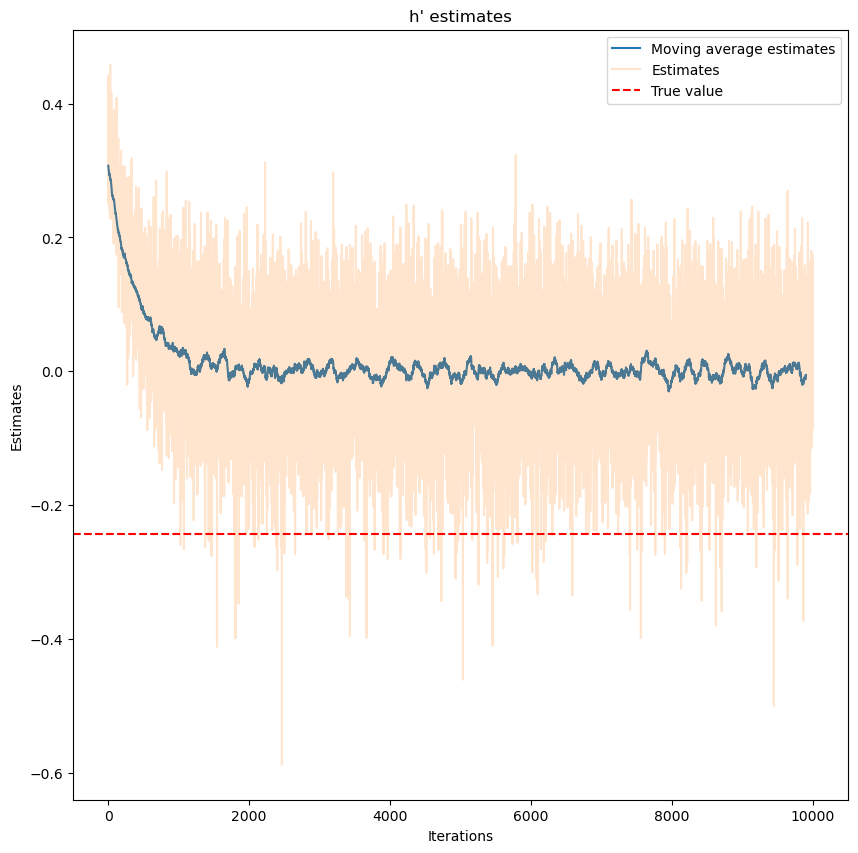

In [43]:
window_width = 100
cumsum_vec = np.cumsum(np.insert(estimates, 0, 0)) 
moving_estimates = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width

fig = plt.figure(figsize=(10, 10))

plt.plot(moving_estimates, label = "Moving average estimates")
plt.plot(estimates, alpha = 0.2, label = "Estimates")
plt.axhline(y=true_val, c='r', linestyle='dashed', label = "True value")
plt.xlabel("Iterations")
plt.ylabel("Estimates")
plt.title("h' estimates")
plt.legend()
plt.show()

In [1]:
import networkx as nx

In [ ]:
import networkx as nx

def min_weight_vertex_cut(graph):
    # Create a copy of the graph
    graph_copy = graph.copy()

    # Add a super-source and super-sink nodes
    super_source = 'super_source'
    super_sink = 'super_sink'
    graph_copy.add_node(super_source)
    graph_copy.add_node(super_sink)

    # Connect the super-source to all nodes with edge weights
    for node in graph_copy.nodes():
        if node != super_source and node != super_sink:
            graph_copy.add_edge(super_source, node, weight=1)  # Set the weight as needed

    # Connect all nodes to the super-sink with edge weights
    for node in graph_copy.nodes():
        if node != super_source and node != super_sink:
            graph_copy.add_edge(node, super_sink, weight=1)  # Set the weight as needed

    # Find the minimum-weight edge cut using NetworkX's minimum_cut function
    cut_value, partition = nx.minimum_cut(graph_copy, super_source, super_sink)

    # Extract the minimum-weight vertex cut from the partition
    vertex_cut = set()
    for node, node_partition in partition.items():
        if node_partition == 0 and node != super_source:
            vertex_cut.add(node)

    # Compute the total minimum cut weight
    min_cut_weight = sum(graph_copy[super_source][node]['weight'] for node in graph_copy[super_source])

    return min_cut_weight, vertex_cut

# Example usage
graph = nx.Graph()
graph.add_edge('A', 'B', weight=3)
graph.add_edge('A', 'C', weight=2)
graph.add_edge('B', 'C', weight=1)

min_cut_weight, vertex_cut = min_weight_vertex_cut(graph)
print("Total minimum cut weight:", min_cut_weight)
print("Vertex cut nodes:", vertex_cut)


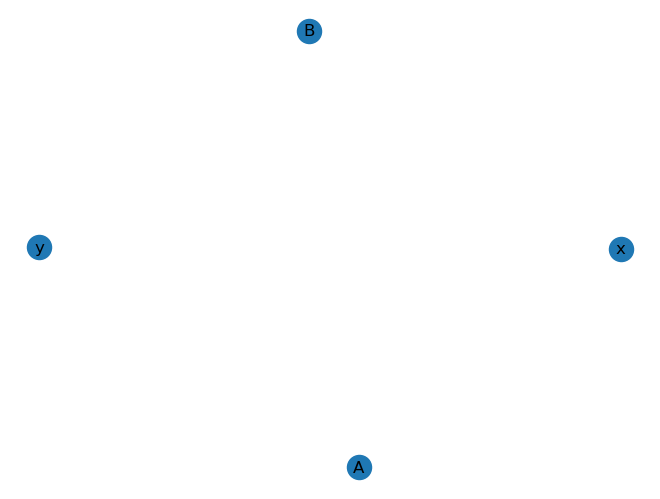

In [11]:
g = nx.Graph()
g.add_edge('A', 'B', weight=3)

g_copy = nx.Graph()

g_copy.add_nodes_from(g.nodes())
g_copy.add_nodes_from("xy")

nx.draw(g_copy, with_labels=True)

